<a href="https://colab.research.google.com/github/liissiigur/IDS-project/blob/main/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#Connecting to GitHub
!git clone https://github.com/liissiigur/IDS-project.git
%cd /content/IDS-project/IDS_data/
!ls

Cloning into 'IDS-project'...
remote: Enumerating objects: 87983, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 87983 (delta 13), reused 11 (delta 2), pack-reused 87923 (from 1)
Receiving objects: 100% (87983/87983), 1.31 GiB | 38.71 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (76196/76196), done.
/content/IDS-project/IDS_data
IDS-project  test  train  valid


In [28]:
#installs
!pip install tensorflow

In [29]:
#imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random

In [30]:
#Specifying folders
train_folder = "train"
val_folder = "valid"
test_folder = "test"

In [48]:
#A function to read in the picture data and corresponding labels for the training and validation data
#The training and validation data are in separate folders, which both have subfolders of different classes
#Each subfolder contains images of this class and the folder name represetns the class (e.g "Apple___healthy" has images of healthy apple leaves)
#Actually the function is a generator that yields data in in batches, because there are a lot of pictures and otherwise the system ran out of RAM

def image_data(folder, batch_size=32):
    # Collect all image paths and labels
    image_paths = []
    labels = []

    class_labels = []  # All unique class labels

    # The class names (folder names) must be encoded to numerical values
    for imfolder in os.listdir(folder):
        folder_path = os.path.join(folder, imfolder)
        if os.path.isdir(folder_path):
            class_labels.append(imfolder)
    label_encoder = LabelEncoder()
    label_encoder.fit(class_labels)  # Assign a number to each class

    # Collect image paths and labels from all subfolders
    for imfolder in os.listdir(folder): #Go through all folders in the train folder (each folder represents a category)
        folder_path = os.path.join(folder, imfolder)
        if os.path.isdir(folder_path):
            for imfile in os.listdir(folder_path): #Go through all of the files (photos) in the subfolder
                image_path = os.path.join(folder_path, imfile)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    labels.append(imfolder)


    # Shuffle the data by shuffling the indexes
    indices = list(range(len(image_paths)))
    random.shuffle(indices)

    while True:
      # Yield data in batches
      X_batch = []
      y_batch = []

      for i in indices:
          image_path = image_paths[i]
          label = labels[i]

          img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2
          if img is not None:
              if img.shape != (256, 256, 3):
                  img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
              img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range
              X_batch.append(img)
              y_batch.append(label)

          # Full batch
          if len(X_batch) >= batch_size:
              X_batch = np.array(X_batch) #Convert to numpy array
              y_batch = label_encoder.transform(y_batch)  #Convert string labels to integers
              y_batch = np.array(y_batch)
              yield X_batch, y_batch
              X_batch = []
              y_batch = []

      #All remaining images that aren't part of a full batch
      if X_batch:
          X_batch = np.array(X_batch)
          y_batch = label_encoder.transform(y_batch) #Convert again
          y_batch = np.array(y_batch)
          yield X_batch, y_batch

# Using the function for training and validation data
train_data = image_data(train_folder)
val_data = image_data(val_folder)



In [49]:
#Defining a convolutional neural network model - need kihid on siin üsna suvaliselt valitud, tuleks testida eri variante, et kas miski on parem
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(os.listdir(train_folder)), activation='softmax') #Output layer is softmax with as many neurons as there are classes. For each class, the probability of the image belonging to this class is given.
])

#Compiling the model - jällegi suvaliselt mingi optimiseerija jms valitud, otsida parimat
model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Estimate number of batches per epoch
train_steps = len(os.listdir(train_folder)) // 32
val_steps = len(os.listdir(val_folder)) // 32

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
history = model.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs=1000,
    validation_data=val_data,
    validation_steps=val_steps,
    verbose = 0
)


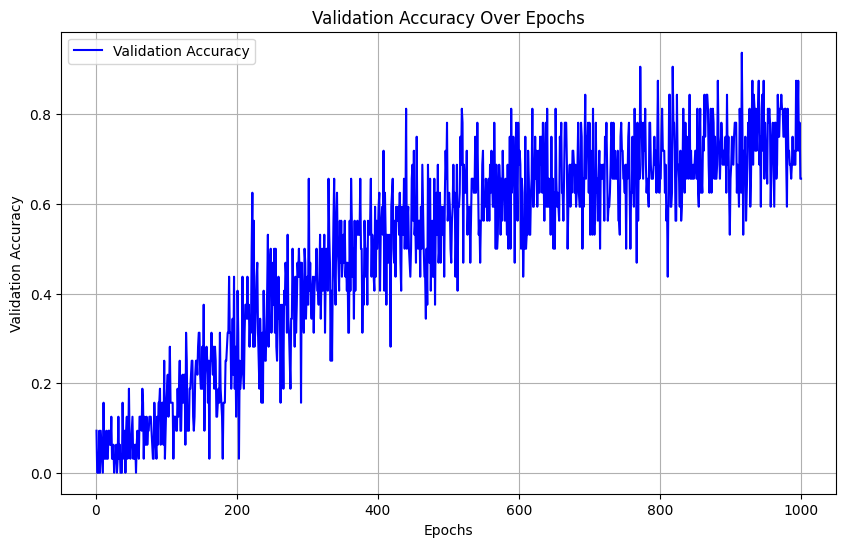

In [51]:
import matplotlib.pyplot as plt

# Extract validation accuracy from the history object
val_accuracy = history.history['val_accuracy']

# Plot the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [52]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import os

# Number of classes
num_classes = len(os.listdir(train_folder))

# Load the ResNet50 model without the top layers
base_model = ResNet50(
    weights='imagenet',  # Use pretrained weights
    include_top=False,   # Exclude the original fully connected layers
    input_shape=(256, 256, 3)  # Match your input image dimensions
)

# Simplified classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Compress features to a single vector per channel
    layers.Dense(num_classes, activation='softmax')  # Final classification layer
])

# Freeze the base ResNet model (optional, for transfer learning)
base_model.trainable = False

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 33)                  │          67,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,655,329 (90.24 MB)

 Trainable params: 67,617 (264.13 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [53]:
history = model.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs=1000,
    validation_data=val_data,
    validation_steps=val_steps
)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step - accuracy: 0.0000e+00 - loss: 4.0868 - val_accuracy: 0.0000e+00 - val_loss: 4.0641
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.0938 - loss: 3.5522 - val_accuracy: 0.0312 - val_loss: 3.8289
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.0000e+00 - loss: 3.7337 - val_accuracy: 0.0312 - val_loss: 4.0370
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.0312 - loss: 3.8931 - val_accuracy: 0.0312 - val_loss: 3.6856
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.0312 - loss: 3.7409 - val_accuracy: 0.0625 - val_loss: 3.7312
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.0000e+00 - loss: 3.7832 - val_accuracy: 0.0000e+00 - val_loss: 3.6032
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.0625 - loss: 3.8631 - val_accuracy: 0.0000e+00 - val_loss: 3.5112
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.0000e+00 - loss

In [54]:
loss, accuracy = model.evaluate(val_data, steps=val_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.1562 - loss: 3.0552


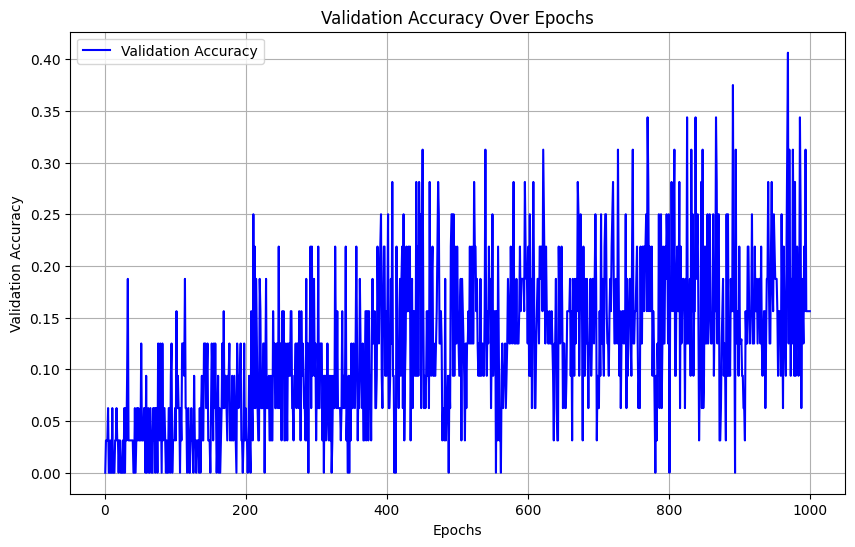

In [55]:
# Extract validation accuracy from the history object
val_accuracy = history.history['val_accuracy']

# Plot the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()